# Modelo de Machine Learning para hacer predicciones
En este documento se muestra el proceso para crear y entrenar el modelo de machine learning para hacer predicciones de las lecturas de los sensores. La obtencion de dichas lecturas se muestra en el archivo "eda.ipynb".

Se resuelve el problema de regresion para series de tiempo (Time Series), es decir, se debe estimar el valor de una variable continua aplicada a series temporales.

## Preprocesamiento de los datos

El preprocesamiento de los datos consiste en:

1. Llenar valores ausentes y eliminar duplicados
2. Eliminar outliers y multicolinealidad
3. Convertir variables categoricas en numericas
4. Estandarizar (escalar) los datos

In [27]:
# Import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import joblib

In [28]:
# Read DataFrame
df = pd.read_csv('../data/processed/factLecturas_2025-09-24 11:41:38.csv', sep=',', header=0)

# Show DataFrame
df.head(3)

,ReadId,TimeSpan,SensorId,Value,LocalTimeSpan
0,05543cf3-ec51-4760-a9af-8efa01a203e6,2025-01-18 13:48:44.190,063276ed-657e-40a2-a17b-0c685af518f6,31.20,2025-01-18 07:48:44.190
1,a3c80788-c698-41cc-835f-aedd98adb72c,2025-01-18 13:48:44.195,22f8b472-4022-41a9-b7b7-37e83a532df0,35.55,2025-01-18 07:48:44.195
2,4e223d79-4791-4c2a-9d88-97c8efa170bc,2025-01-18 13:48:44.199,267e3d44-9b7f-460c-b34b-603fe0fa9972,36.90,2025-01-18 07:48:44.199


In [29]:
# DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165411 entries, 0 to 165410
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ReadId         165411 non-null  object 
 1   TimeSpan       165411 non-null  object 
 2   SensorId       165411 non-null  object 
 3   Value          165411 non-null  float64
 4   LocalTimeSpan  165411 non-null  object 
dtypes: float64(1), object(4)
memory usage: 6.3+ MB


In [30]:
# Change date column to datetime
df['TimeSpan'] = pd.to_datetime(df['TimeSpan'])
df['LocalTimeSpan'] = pd.to_datetime(df['TimeSpan'])

# DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165411 entries, 0 to 165410
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ReadId         165411 non-null  object        
 1   TimeSpan       165411 non-null  datetime64[ns]
 2   SensorId       165411 non-null  object        
 3   Value          165411 non-null  float64       
 4   LocalTimeSpan  165411 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(2)
memory usage: 6.3+ MB


### Llenar valores ausentes y eliminar duplicados

In [4]:
# Verify null values per column
print(df.isna().sum())

ReadId           0
TimeSpan         0
SensorId         0
Value            0
LocalTimeSpan    0
dtype: int64


In [32]:
# Delete all row duplicates
df = df.drop_duplicates(subset=['ReadId'])

# Count duplicates
df.duplicated(subset=['ReadId']).sum()

0

### Eliminar outliers y multicolinealidad
Se procederá a eliminar el 5% de los valores del extremo superior. Estos valores atipicos pueden distorcionar los resultados, generando predicciones un poco superiores a las reales.

In [33]:
# Limit outliers to percentile 95
percentile95 = df['Value'].quantile(0.95)
for index,value in df['Value'].items():
    if value > percentile95:
        df.loc[index,'Value'] = percentile95

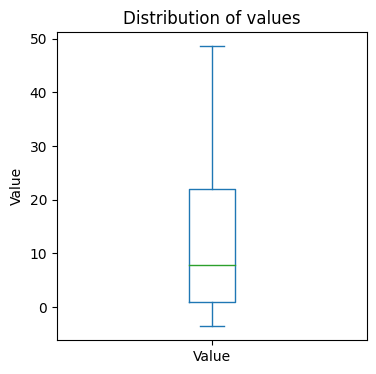

In [34]:
# Box plot
df['Value'].plot(kind='box', figsize=[4,4], title='Distribution of values',
                 ylabel='Value')
plt.xticks(rotation=0)
plt.show()

Parece que las columnas 'TimeSpan' y 'LocalTimeSpan' solo varian por unas horas, es decir, es la misma informacion.

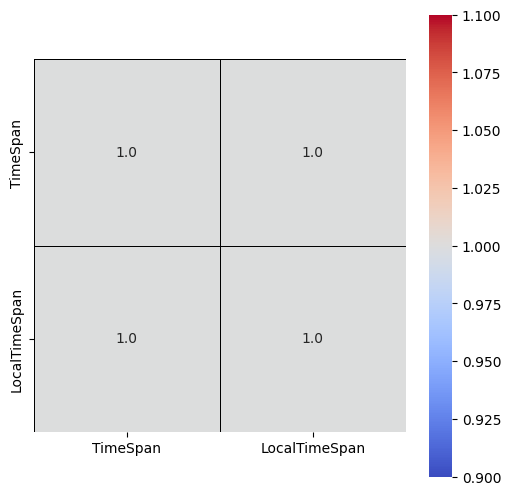

In [35]:
df_split = df[['TimeSpan','LocalTimeSpan']]

# Heatmap
plt.figure(figsize = (6,6))
sns.heatmap(df_split.corr(), annot=True, square=True, cmap='coolwarm',
            fmt='.1f',annot_kws={"size": 10}, linewidths=0.5, linecolor='black')
plt.show()

Efectivamente, las columnas 'TimeSpan' y 'LocalTimeSpan' contienen la misma informacion, por lo tanto, se ignorara la columna 'LocalTimeSpan'.

In [37]:
# Extract columns
df = df[['ReadId', 'TimeSpan', 'SensorId', 'Value']]

### Convertir variables categoricas en numericas
La unica variable categorica es 'ReadId', pero no es relevante para el modelo de prediccion de valores medidos por el sensor, por lo tanto, la columna 'ReadId' tambien sera ignorada.


In [40]:
# Extract columns
df = df[['TimeSpan', 'SensorId', 'Value']]

# DataFrame columns
print(df.columns)

Index(['TimeSpan', 'SensorId', 'Value'], dtype='object')


### Estandarizar (escalar) los datos
El escalamiento de los datos no aplica para series temporales, ademas, se usara el modelo 'RandomForestRegressor', en el cual no es necesario escalar los datos.

## Planteamiento del problema
Se tiene un total de 165,407 mediciones de 40 sensores diferentes.

In [43]:
# DataFrame shape
print(df.shape)

(165407, 3)


In [42]:
# Count unique values
print(df['SensorId'].nunique())

40
